# Una mirada al mundo de la especulación

### Imports

In [412]:
import requests
from requests_html import AsyncHTMLSession
import pandas as pd
import matplotlib.pyplot as plt
import json
import secret
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import nest_asyncio


In [ ]:
nest_asyncio.apply()

### Config:

### 1) Twitter scrapping

In [34]:
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(executable_path=os.path.abspath("chromedriver"), chrome_options=chrome_options)

c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  
c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


In [39]:
driver.get("https://twitter.com/search?q=bitcoin&src=typed_query")

c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  


[]

El siguiente codigo se va a tomar bastante tiempo, ya que literalmente tiene que navegar por twitter en un browser oculto

In [450]:
from datetime import datetime
import time


def get_articles():
    articles = []
    for _ in range(100):
        try:
            el = driver.find_elements(By.TAG_NAME, "article")

            html = driver.find_element(By.TAG_NAME, 'html')

            my = []
            for e in el:
                article = e.text.split("\n")
                if article[-1] == "Show this thread":
                    article[-1] = ""
                publisher = (article[0], article[1])
                date = e.find_element(By.TAG_NAME, "time").get_attribute("datetime")
                date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.000Z')
                article = [x for x in article if len(x) >= 5]
                pub = ('\n'.join([at for at in article[4:] if
                                  at.strip('\t').strip(' ') != "" and not at.strip('\t').strip(' ').isdigit()])).replace(
                    '.\n', '. ').replace('\n', '. ')

                if len(list(filter(lambda x: x[0] == publisher and x[1] == date and x[2] == pub, articles))) == 0:
                    articles.append((publisher, date, pub))
                    print(len(articles))

            e.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.3)
            e.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.28)
            e.send_keys(Keys.PAGE_DOWN)

            time.sleep(0.5)
        except Exception as e:
            print("ERROR: ",e)
    return articles


articles = get_articles()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


KeyboardInterrupt: 

In [454]:
#publisher_names = [article[0][0] for article in articles]
publisher_ids = [article[0][1][1:] for article in articles]
publisher_tweet_dates = [article[1].timestamp() for article in articles]
publisher_tweets = [article[2] for article in articles]

conv = zip(publisher_ids, publisher_tweet_dates, publisher_tweets)

df = pd.DataFrame(list(conv), columns=['p_id', 'date', 'tweet'])

Ahora cargemos lo que previamente teniamos en tweets.csv (No es necesario si es la primera vez que se corre el codigo)

In [304]:
if os.path.isfile("data/tweets.csv"):
    old_tweets = pd.read_csv("data/tweets.csv")
    df = df.append(old_tweets)
    df = df.drop_duplicates()

Convertir los tweets y guardarlos para el futuro

In [484]:
df.to_csv("data/tweets.csv")
df.head()

,p_id,date,tweet
0,DeAiDave,1.639348e+09,This is what #BTC maxis are missing. . New tec...
1,CriptoVitoko,1.639348e+09,"Die Bears, Die!! #Bitcoin. GIF"
2,Dan_Xuereb,1.639348e+09,Back to the 40s #bitcoin. GIF
3,CryptoSniper24,1.639348e+09,$IMX #IMX. Decision time . #Bitcoin $BTC . #Bi...
4,TuurDemeester,1.639348e+09,Some buzz going around about Paraguay potentia...


Ahora podemos empezar con el DataCleanup

Eliminar las filas en donde el tweet está vacío

In [485]:
import numpy as np
p_len = len(df)
df['tweet'].replace('', np.nan, inplace=True)
df.dropna(subset=['tweet'], inplace=True)
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

1 tweets eliminado(s)! (24882 restantes)


Eliminar las filas donde el tweet tiene menos de 188 characteres, para solo tener los tweets donde el texto es importante (no solo los archivos como imagenes o videos)

El 188 fue elegido ya que el promedio de characteres de una palabra en inglés (Estamos tomando los tweets en inglés ya que son los más influenciadores) es 4.7, por lo tanto si queremos 40 palablas minimo, usamos 188

In [497]:
p_len = len(df)
df = df[df['tweet'].str.len() > 188]
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

0 tweets eliminado(s)! (7431 restantes)


Eliminar usernames con espacios

In [498]:
p_len = len(df)
df = df[~(df['p_id'].str.contains(" "))]
df['p_id'].replace('', np.nan, inplace=True)
df.dropna(subset=['p_id'], inplace=True)
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

0 tweets eliminado(s)! (7431 restantes)


In [488]:
df["p_id"].unique()

array(['DeAiDave', 'CryptoSniper24', 'TuurDemeester', ..., 'ChefGruel',
       'tuihane_', 'yaneuraou'], dtype=object)

Con los tweets no utiles removidos del dataframe, ahora podemos ir a twitter a buscar la data de los usuarios restantes sin tener que hacer un request más largo al api, para después igual eliminar esos usuarios

In [489]:
def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {secret.bearer_token}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r


def get_users(users_list):
    usernames = f"usernames={','.join(users_list)}"
    user_fields = "user.fields=public_metrics,verified"
    url = "https://api.twitter.com/2/users/by?{}&{}".format(usernames, user_fields)
    response = requests.request("GET", url, auth=bearer_oauth, )
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()


# Only 300-requests/15-min to not be banned
users_list = list(set([user for user in df["p_id"]]))

print(f"{len(users_list)} unique users")

json_response = []
for i in range(0, len(users_list), 100):
    usrs = users_list[i:i + 100]
    print(f"Getting {len(usrs)*(i+1)}/{len(users_list)} users")
    n_u = get_users(usrs)["data"]
    print(len(n_u))
    json_response.extend(n_u)

4478 unique users
Getting 100/4478 users
100
Getting 10100/4478 users
100
Getting 20100/4478 users
100
Getting 30100/4478 users
100
Getting 40100/4478 users
100
Getting 50100/4478 users
100
Getting 60100/4478 users
100
Getting 70100/4478 users
100
Getting 80100/4478 users
100
Getting 90100/4478 users
100
Getting 100100/4478 users
100
Getting 110100/4478 users
100
Getting 120100/4478 users
100
Getting 130100/4478 users
100
Getting 140100/4478 users
99
Getting 150100/4478 users
100
Getting 160100/4478 users
100
Getting 170100/4478 users
100
Getting 180100/4478 users
100
Getting 190100/4478 users
100
Getting 200100/4478 users
100
Getting 210100/4478 users
100
Getting 220100/4478 users
100
Getting 230100/4478 users
99
Getting 240100/4478 users
100
Getting 250100/4478 users
100
Getting 260100/4478 users
100
Getting 270100/4478 users
100
Getting 280100/4478 users
100
Getting 290100/4478 users
100
Getting 300100/4478 users
100
Getting 310100/4478 users
100
Getting 320100/4478 users
100
Gettin

In [512]:
usernames = []
followers = []
following = []
listed_count = []
tweet_count = []
verified = []

u_ids = df["p_id"].unique()
for usr in json_response:
    if usr["username"] not in u_ids:
        continue
    usernames.append(usr["username"])
    followers.append(usr["public_metrics"]["followers_count"])
    following.append(usr["public_metrics"]["following_count"])
    listed_count.append(usr["public_metrics"]["listed_count"])
    tweet_count.append(usr["public_metrics"]["tweet_count"])
    verified.append(int(usr["verified"]))

df_users = pd.DataFrame(zip(usernames, followers, following, listed_count, tweet_count, verified),
                        columns=['username', 'followers', 'following', 'listed count', 'tweet count', 'verified'])
df_users

,username,followers,following,listed count,tweet count,verified
0,ThInvestForum,44478,85,0,12108,0
1,FerghaneA,28732,1166,167,17617,0
2,MrPlanN,14997,747,6,6274,0
3,peterhuntcrypto,151121,7463,57,9726,0
4,spiralbtc,104217,1,1471,828,1
...,...,...,...,...,...,...
1869,Crypto_Hawkk,392934,69,320,908,0
1870,dergigi,46790,962,950,48905,0
1871,ShibaAustralia,89798,1594,100,20145,0
1872,boardroom,65868,2371,293,6017,1


Ahora, hacemos el data cleanup de los usuarios y de los tweets que tienen a sus nombres


Eliminar los usuarios que tienen pocos seguidores:

In [533]:
p_len = len(df_users)
df_users = df_users[df_users['followers'] > 150000]
df_users.head()
print(f"{p_len-len(df_users)} usuarios eliminado(s)! ({len(df_users)} restantes)")

155 usuarios eliminado(s)! (608 restantes)


Eliminar usuarios con similar cantidad de followers que following o incluso menor followers que following (Muchos tienen seguidores porque siguen de regreso y no tienen mucho valor en este proyecto)

En este caso, la diferencia entre los followers y following, deben ser mayores a el 80% de la suma de estos

In [534]:
p_len = len(df_users)
df_users = df_users[df_users['followers']-df_users['following'] > (df_users['followers']+df_users['following'])*0.8]
print(f"{p_len-len(df_users)} usuarios eliminado(s)! ({len(df_users)} restantes)")
df_users

0 usuarios eliminado(s)! (608 restantes)


,username,followers,following,listed count,tweet count,verified
3,peterhuntcrypto,151121,7463,57,9726,0
8,rssurjewala,1727123,151,798,14742,1
11,goto_nikkei,285278,162,3242,3285,1
14,DrogCrypto,201501,362,527,18604,0
18,NewYorker,8994296,399,64198,131339,1
...,...,...,...,...,...,...
1859,shl,264192,24,4070,27785,1
1863,itsALLrisky,238236,507,414,14530,0
1866,garciabanchs,358529,2032,2042,137238,1
1869,Crypto_Hawkk,392934,69,320,908,0


Ahora, borramos los tweets de los usuarios que no están en la lista

In [535]:
p_len = len(df)
df = df[df['p_id'].isin(df_users["username"])]
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

539 tweets eliminado(s)! (4814 restantes)


Ahora que tenemos la data 'limpia', podemos empezar a identificar el sentimiento de los tweets que quedan, para luego hacer regression para saber cuanto puede un usuario afectar los tweets, luego hacer k-cluster para saber los datos más importantes.

In [549]:
# Test sentiment

tweet_neg = []
tweet_neu = []
tweet_pos = []
tweet_vpos = []
tweet_vneg = []

tweet_beg = []
tweet_end = []

for t_id, tweet in enumerate(df["tweet"]):
    print(f"{t_id + 1}/{len(df['tweet'])}\r", end="")

    for error_n in range(50):
        try:
            r = requests.post(
                "https://api.deepai.org/api/sentiment-analysis",
                data={
                    'text': tweet,
                },
                headers={'api-key': secret.sentiment_key}
            )
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(10+error_n)
    for error_n in range(10):
        try:
            phrases = r.json()["output"]
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(1)
    if error_n == 9:
        print("Could not solve!")
        continue

    tweet_beg.append(phrases[0])
    tweet_end.append(phrases[-1])
    phs_vneg = 0
    phs_neg = 0
    phs_neu = 0
    phs_pos = 0
    phs_vpos = 0
    for ph in phrases:
        phs_vneg += ph == "Verynegative"
        phs_neg += ph == "Negative"
        phs_neu += ph == "Neutral"
        phs_pos += ph == "Positive"
        phs_vpos += ph == "Verypositive"
        if ph not in ["Verynegative", "Negative", "Neutral", "Positive", "Verypositive"]:
            print(f"New state found'{ph}'")
    tweet_vneg.append(phs_vneg)
    tweet_neg.append(phs_neg)
    tweet_neu.append(phs_neu)
    tweet_pos.append(phs_pos)
    tweet_vpos.append(phs_vpos)

print("Done!" + " "*20)

Done!                    


In [550]:
df['sentiment_begin'] = tweet_beg
df['sentiment_end'] = tweet_end

df['sentiment_very_positive'] = tweet_vpos
df['sentiment_positive'] = tweet_pos
df['sentiment_neutral'] = tweet_neu
df['sentiment_negative'] = tweet_neg
df['sentiment_very_negative'] = tweet_vneg

df

,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_very_negative
4,TuurDemeester,1.639348e+09,Some buzz going around about Paraguay potentia...,Negative,Negative,0,0,2,4,0
16,rektcapital,1.639348e+09,Over 70% of #BTC investors believe that Bitcoi...,Negative,Neutral,0,0,9,1,0
24,DiMartinoBooth,1.639347e+09,“I don’t want to be overly technical but … the...,Negative,Negative,0,0,2,3,0
108,shibainuart,1.639341e+09,"$SHIB x Turkey ? Wow. coindesk.com. Tether, SH...",Negative,Neutral,0,1,2,3,0
173,OpIndia_com,1.639336e+09,"According to sources, the Ministry of Electron...",Negative,Neutral,0,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...
24864,theRealKiyosaki,1.609522e+09,Happy New Year. 2021 great year for gold silve...,Positive,Positive,0,4,2,1,0
24870,woonomic,1.609507e+09,#Bitcoin is the first invention of an Internet...,Negative,Negative,0,0,4,2,0
24872,woonomic,1.609506e+09,If you're looking for an entry to HODL Bitcoin...,Negative,Negative,0,0,2,3,0
24878,jackmallers,1.609470e+09,What’s now known: You can’t save in USD. . Wha...,Negative,Neutral,0,3,4,2,0


In [551]:
#SAVING FOR NOW
df.to_csv("tweet_sentiment.csv")
df_users.to_csv("users.csv")

Ahora podemos probar algunos de los tweets para saber si son clasificados correctamente

In [341]:
df[df["sentiment_positive"] > df["sentiment_negative"]].head()

,p_name,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_very_negative
20,Dan Tapiero,DTAPCAP,1.639240e+09,This is what hyperbitcoinization looks like:. ...,Neutral,Neutral,0,1,3,0,0
24,Natalie ₿runell,natbrunell,1.638594e+09,He wanted to pose in front of the #Bitcoin art...,Positive,Neutral,0,2,2,0,0
43,Hakuna MATATA,HMatataOfficial,1.639327e+09,Hakuna Matata Presale. Starting will be live o...,Neutral,Neutral,0,2,11,0,0
44,Michael Saylor,saylor,1.639328e+09,#Bitcoin is growing stronger behind a wall of ...,Positive,Neutral,0,3,4,0,0
46,Crypto Beast,CryptooBeast,1.639334e+09,"To Celebrate 100,000 I will gift. $1000 in #...",Positive,Neutral,0,2,5,0,0


Lo anterior, demuestra que las clasificaciónes son bastante buenas

Lo unico que nos queda por cargar son los valores del Bitcoin. Estos se consiguieron por scrapping de CoinMarketCap. Pero prefiero no publicar el codigo utilizado, por miedo a que arreglen el bug que permite esta recoleción de datos

In [468]:
df_btc = pd.read_csv("data/btc_values.csv")
df_btc.head()

,timestamp,price
0,1639356991,49804.781575
1,1639356842,49804.781575
2,1639356542,49875.796875
3,1639356242,49887.287153
4,1639355942,49798.770567


El dataframe de precios, está compuesto de 2 columnas, timestamp y price donde timestamp es la fecha en formato unix timestamp

Ahora podemos hacer una grafico para hacernos una idea de lo que tenemos que hacer

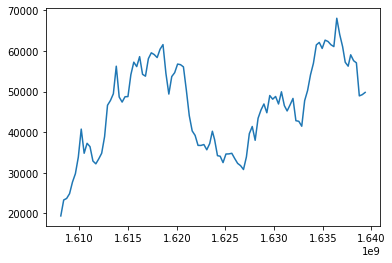

In [469]:
fig = plt.plot('timestamp', 'price', data=df_btc[::1000])

Ahora, encontremos los extremos temporales de los tweets, para no tener que mostrar todo el historial que tenemos disponible

In [415]:
max = np.max(df['date'])
min = np.min(df['date'])

def get_price_near(timestamp):
    return df_btc.iloc[(df_btc['timestamp']-timestamp).abs().argsort()[0]]["price"]


In [416]:
p_len = len(df_btc)
df_btc = df_btc[df_btc["timestamp"] > min]
df_btc = df_btc[df_btc["timestamp"] < max]
print(f"{p_len-len(df_btc)} fechas eliminadas ({len(df_btc)} restantes)")

0 fechas eliminadas (2882 restantes)


Ahora, encontremoas a un tweet al azar y mostremoslo en el grafico

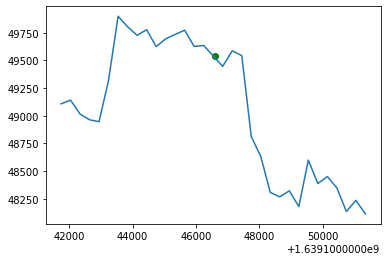

In [417]:
tweet_date = df.iloc[8]['date']

df_btc_short = df_btc[df_btc["timestamp"] > tweet_date-5000]
df_btc_short = df_btc_short[df_btc_short["timestamp"] < tweet_date+5000]

fig = plt.plot('timestamp', 'price', data=df_btc_short)
plt.scatter(tweet_date, get_price_near(tweet_date), color='green')

Nos podemos dar cuenta de que nos estamos acercando a nuestro objetivo, ahora hay que ver "cuanto" cambia el precio del bitcoin después de cada tweet

Para esto, vamos a crear 6 nuevas columnas a los tweets: Los deltas de los precios después de 5 min, 30 min, 1h, 5h, 1d, 7d

In [425]:
min_5 = 5*60
min_30 = 30*60
hour_1 = 60*60
hour_5 = 5*hour_1
day_1= 24*hour_1
day_7 = 7*day_1

time_5m = []
time_30m = []
time_1h = []
time_5h = []
time_1d = []
time_7d = []

for tweet_date in df.date:
    now_price = get_price_near(tweet_date)
    time_5m.append(get_price_near(tweet_date+min_5)-now_price)
    time_30m.append(get_price_near(tweet_date+min_30)-now_price)
    time_1h.append(get_price_near(tweet_date+hour_1)-now_price)
    time_5h.append(get_price_near(tweet_date+hour_5)-now_price)
    time_1d.append(get_price_near(tweet_date+day_1)-now_price)
    time_7d.append(get_price_near(tweet_date+day_7)-now_price)

df["price_delta_5m"] = time_5m
df["price_delta_30m"] = time_30m
df["price_delta_1h"] = time_1h
df["price_delta_5h"] = time_5h
df["price_delta_1d"] = time_1d
df["price_delta_7d"] = time_7d

In [426]:
df.head()

,p_name,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_very_negative,price_delta_5m,price_delta_30m,price_delta_1h,price_delta_5h,price_delta_1d,price_delta_7d
0,Cryptoes#21MA,cryptoes_,1.639347e+09,Can #Bitcoin get over the 21W MA at $52K befor...,Negative,Negative,0,0,0,1,0,13.596268,13.596268,13.596268,13.596268,13.596268,13.596268
1,Danielle DiMartino Booth,DiMartinoBooth,1.639347e+09,“I don’t want to be overly technical but … the...,Negative,Negative,0,0,2,3,0,13.596268,13.596268,13.596268,13.596268,13.596268,13.596268
2,Grady Booch,Grady_Booch,1.639347e+09,Replying to . @tvitzer. @ThomasBurkhartB. an...,Neutral,Negative,0,0,4,1,0,13.596268,13.596268,13.596268,13.596268,13.596268,13.596268
3,Blockmine3rz,bmine3rz,1.639347e+09,Bitman Antminer T9+ Bitcoin ASIC Miner w/PSU –...,Negative,Negative,0,0,1,2,0,13.596268,13.596268,13.596268,13.596268,13.596268,13.596268
4,Dan Tapiero,DTAPCAP,1.639240e+09,This is what hyperbitcoinization looks like:. ...,Neutral,Neutral,0,1,3,0,0,100.599005,-76.579004,-131.648457,-533.485991,447.066989,875.015529


Ahora podemos empezar con la regreción

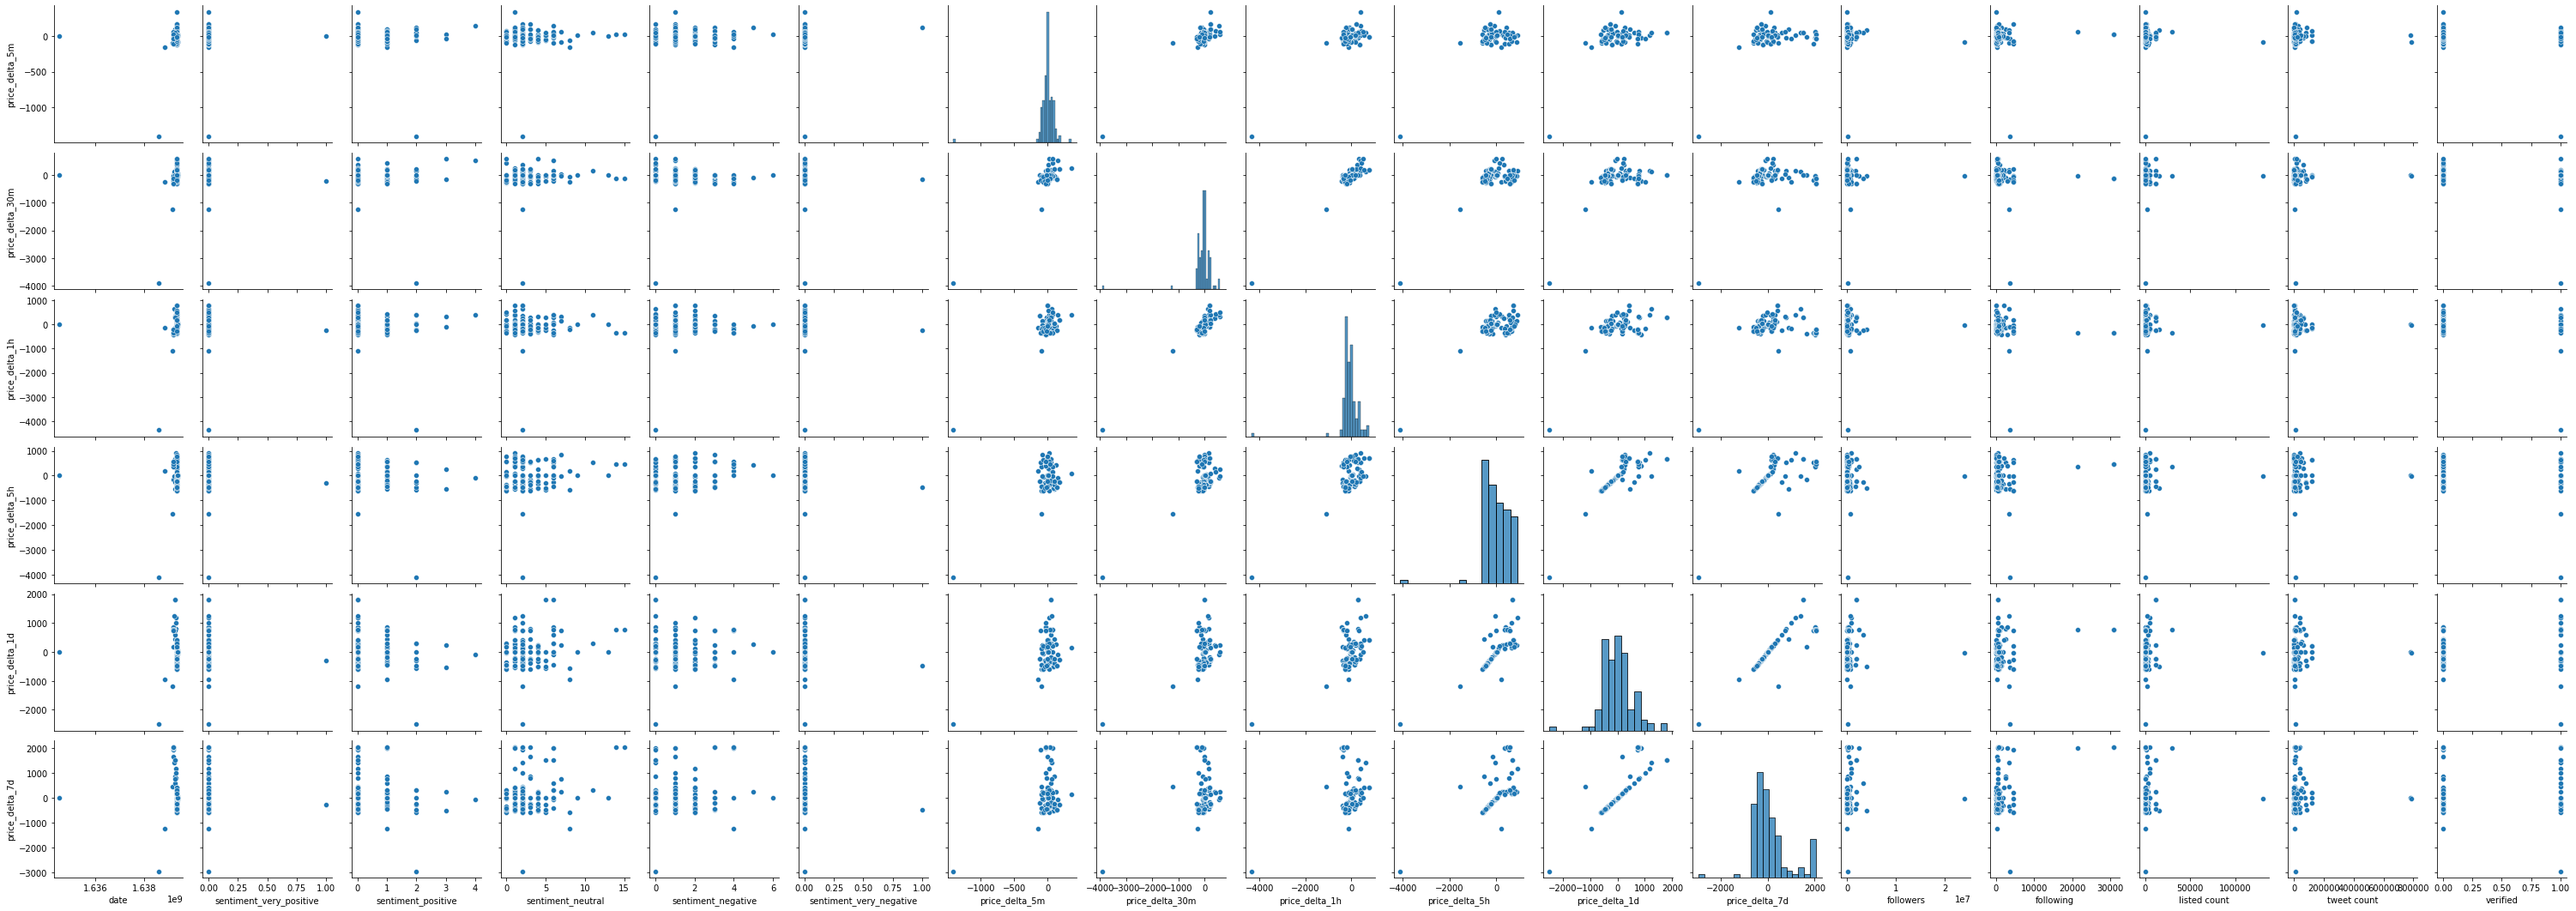

In [443]:
df_analysis = pd.DataFrame(df)

followers = []
following = []
listed_count = []
tweet_count = []
verified = []

for user in df.iloc:
    usr = df_users[df_users["username"] == user["p_id"]].iloc[0]
    followers.append(usr["followers"])
    following.append(usr["following"])
    listed_count.append(usr["listed count"])
    tweet_count.append(usr["tweet count"])
    verified.append(usr["verified"])

df_analysis["followers"] = followers
df_analysis["following"] = following
df_analysis["listed count"] = listed_count
df_analysis["tweet count"] = tweet_count
df_analysis["verified"] = verified

df_analysis = df_analysis.drop(["p_name", "p_id", "date", "tweet", "sentiment_begin", "sentiment_end"], axis="columns")

In [442]:
sns.pairplot(df,y_vars=['price_delta_5m', 'price_delta_30m', 'price_delta_1h', 'price_delta_5h', 'price_delta_1d', 'price_delta_7d'])

,p_name,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,...,price_delta_30m,price_delta_1h,price_delta_5h,price_delta_1d,price_delta_7d,followers,following,listed count,tweet count,verified
0,Cryptoes#21MA,cryptoes_,1.639347e+09,Can #Bitcoin get over the 21W MA at $52K befor...,Negative,Negative,0,0,0,1,...,13.596268,13.596268,13.596268,13.596268,13.596268,14236,261,108,6281,0
1,Danielle DiMartino Booth,DiMartinoBooth,1.639347e+09,“I don’t want to be overly technical but … the...,Negative,Negative,0,0,2,3,...,13.596268,13.596268,13.596268,13.596268,13.596268,167730,488,2972,120349,1
2,Grady Booch,Grady_Booch,1.639347e+09,Replying to . @tvitzer. @ThomasBurkhartB. an...,Neutral,Negative,0,0,4,1,...,13.596268,13.596268,13.596268,13.596268,13.596268,79242,512,1480,75525,1
3,Blockmine3rz,bmine3rz,1.639347e+09,Bitman Antminer T9+ Bitcoin ASIC Miner w/PSU –...,Negative,Negative,0,0,1,2,...,13.596268,13.596268,13.596268,13.596268,13.596268,57522,19,1749,778025,0
4,Dan Tapiero,DTAPCAP,1.639240e+09,This is what hyperbitcoinization looks like:. ...,Neutral,Neutral,0,1,3,0,...,-76.579004,-131.648457,-533.485991,447.066989,875.015529,81145,2562,1700,6090,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Chief BULLISH Officer $AMP $ŁTC,TheJohnKimShow,1.639336e+09,It's just a blip in the grand scheme of things...,Negative,Neutral,0,0,4,1,...,-225.319388,-140.415281,-495.218155,-495.218155,-495.218155,18583,442,69,11868,0
124,Bitcoinbro.Eth,Bitcoinbro10,1.639174e+09,$100 || RT in 24 hours . Like the quoted tweet...,Negative,Negative,0,0,14,4,...,-105.500946,-338.473126,474.007198,778.828990,2041.778431,289150,30860,510,3571,0
125,SafeMoon Rich,SafeMoonRich,1.639175e+09,$RBUNNY may pump HARD today. Lots of YouTube i...,Negative,Neutral,0,1,3,3,...,-295.542989,-188.892939,588.675049,734.063803,2050.954765,218102,722,484,8044,0
126,"Excel Trading - Charts, Live Streams and Videos",ExcelTrading1,1.639335e+09,Want to try trading? I'm giving away a $300 #b...,Neutral,Negative,0,0,2,3,...,-9.359774,-279.312947,-465.697302,-465.697302,-465.697302,13009,139,36,3605,0
